### Read files

In [1]:
import glob, re
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn import *

data = {
    #visitors
    'tra': pd.read_csv('./input/air_visit_data.csv',parse_dates=["visit_date"]),
    #reservations
    'ar': pd.read_csv('./input/air_reserve.csv',parse_dates=["visit_datetime","reserve_datetime"]),
    'hr': pd.read_csv('./input/hpg_reserve.csv',parse_dates=["visit_datetime","reserve_datetime"]),
    #store info
    'as': pd.read_csv('./input/air_store_info.csv'),
    'hs': pd.read_csv('./input/hpg_store_info.csv'),
    #air<->hpg
    'id': pd.read_csv('./input/store_id_relation.csv'),
    #days
    'hol': pd.read_csv('./input/date_info.csv',parse_dates=["calendar_date"]), #.rename(columns={'calendar_date':'visit_date'})
    #
    'tes': pd.read_csv('./input/sample_submission.csv'),
    }

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\lda.py:6: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)
C:\ProgramData\Anacon

In [38]:
def RMSLE(y, pred):
    return metrics.mean_squared_error(np.log(y+1), np.log(pred+1))**0.5
def RMSE(y, pred):
    return metrics.mean_squared_error(y, pred)**0.5

### Some data categorizing to reduce space

In [3]:
import sys
data["tra"]["air_store_id"]=data["tra"]["air_store_id"].astype('category')
total=0
for k,v in data.items():
    size_k=sys.getsizeof(data[k])/1024/1024
    total+=size_k
    print(k,size_k)
print("total",total)

tra 4.42775821685791
ar 8.898050308227539
hr 192.67313385009766
as 0.23502159118652344
hs 1.3301172256469727
id 0.022129058837890625
hol 0.039612770080566406
tes 2.9315261840820312
total 210.5573492050171


In [4]:
data["tra"]["air_store_id"]=data["tra"]["air_store_id"].astype('category')
data["as"]["air_store_id"]=data["as"]["air_store_id"].astype('category')
data["as"]["air_genre_name"]=data["as"]["air_genre_name"].astype('category')
data["as"]["air_area_name"]=data["as"]["air_area_name"].astype('category')
data["hs"]["hpg_store_id"]=data["hs"]["hpg_store_id"].astype('category')
data["hs"]["hpg_genre_name"]=data["hs"]["hpg_genre_name"].astype('category')
data["hs"]["hpg_area_name"]=data["hs"]["hpg_area_name"].astype('category')
data["ar"]["air_store_id"]=data["ar"]["air_store_id"].astype('category')
data["hr"]["hpg_store_id"]=data["hr"]["hpg_store_id"].astype('category')
data["id"]["hpg_store_id"]=data["id"]["hpg_store_id"].astype('category')
data["id"]["air_store_id"]=data["id"]["air_store_id"].astype('category')
data["hol"]["day_of_week"]=data["hol"]["day_of_week"].astype('category')
data["hol"]["holiday_flg"]=data["hol"]["holiday_flg"].astype('category')

In [5]:
total=0
for k,v in data.items():
    size_k=sys.getsizeof(data[k])/1024/1024
    total+=size_k
    print(k,size_k)
print("total",total)

tra 4.42775821685791
ar 2.323484420776367
hr 51.20259189605713
as 0.13867950439453125
hs 0.6168069839477539
id 0.032466888427734375
hol 0.005854606628417969
tes 2.9315261840820312
total 61.679168701171875


### test

In [6]:
data["tes"][["store_id","time"]]=data["tes"]["id"].str.split("_2017",expand=True)
data["tes"]["time"]="2017"+data["tes"]["time"]
from dateutil import parser
data["tes"]["time"] = pd.to_datetime(data["tes"]["time"])
#data["tes"]["kind"]=data["tes"]["id"].str.split("_",expand=True)[0] #they are all air type

In [7]:
#data["tes_a"]=data["tes"][data["tes"].kind=="air"]
#data["tes_h"]=data["tes"][data["tes"].kind=="hpg"]

In [8]:
print(data["tes"].dtypes)
#data["tes"].head(5)

id                  object
visitors             int64
store_id            object
time        datetime64[ns]
dtype: object


In [9]:
#print(len(data["tes"].store_id.unique()), len(data["tes"].time.unique()), len(data["tes"].id))
#print(len(data["tes_a"].store_id.unique()), len(data["tes_a"].time.unique()), len(data["tes_a"].id))

I add the test dates/stores to the train df

In [10]:
print(len(data["tra"]))

252108


In [11]:
data["tra"]
test_dates=data["tes"]["time"].unique()
test_stores=data["tes"]["store_id"].unique()

days = pd.DataFrame({'visit_date':test_dates})
stores = pd.DataFrame({'air_store_id':test_stores})
stores['key'] = 0
days['key'] = 0
days_and_stores = days.merge(stores, how='left', on = 'key')
days_and_stores.drop('key',1, inplace=True)
days_and_stores

data["tra"]=data["tra"].append(days_and_stores)

In [12]:
print(len(days_and_stores))
print(len(data["tra"]))
#data["tra"]

32019
284127


### Analysis

In [13]:
#%matplotlib inline
#%matplotlib notebook
#data["tra"].groupby("visit_date").mean().plot()

Join dataframes 

In [14]:
store_mean=pd.DataFrame()
store_mean["mean"]=data["tra"].groupby("air_store_id").visitors.mean()
store_mean["min"]=data["tra"].groupby("air_store_id").visitors.min()
store_mean["max"]=data["tra"].groupby("air_store_id").visitors.max()
store_mean["std"]=data["tra"].groupby("air_store_id").visitors.std()
store_mean
data["as"]=data["as"].merge(store_mean,left_on="air_store_id",right_index=True)

In [15]:
#len(data["as"])
data["as"].head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude,mean,min,max,std
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,26.827715,1.0,75.0,13.598164
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,13.467085,1.0,65.0,12.679331
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,26.027778,2.0,53.0,9.799697
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,44.595745,10.0,109.0,24.796265
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7.074689,1.0,28.0,4.773475


In [16]:
data["tra"]["month"]=data["tra"].visit_date.map(lambda x: x.month)
data["tra"]["month"]=data["tra"]["month"].astype('category')

In [17]:
data["tra_as_hol"]=data["tra"].merge(data["hol"],left_on="visit_date",right_on="calendar_date").\
            drop("calendar_date",axis=1).\
            merge(data["as"],on="air_store_id")

In [18]:
#data["tra_as_hol"].describe(include="all")

In [19]:
data["tra_as_hol"]["time_numeric"]=pd.to_numeric(data["tra_as_hol"].visit_date-data["tra_as_hol"].visit_date.min())/100000

In [20]:
data["tra_as_hol"]["time_numeric"].describe()

count    2.841270e+05
mean     2.672911e+11
std      1.157349e+11
min      0.000000e+00
25%      1.857600e+11
50%      2.756160e+11
75%      3.654720e+11
max      4.458240e+11
Name: time_numeric, dtype: float64

In [21]:
data["tra_as_hol"]["visitors"]=np.log1p(data["tra_as_hol"]["visitors"])

In [22]:
data["tra_as_hol"].head()

,air_store_id,visit_date,visitors,month,day_of_week,holiday_flg,air_genre_name,air_area_name,latitude,longitude,mean,min,max,std,time_numeric
0,air_ba937bf13d40fb24,2016-01-13,3.258097,1,Wednesday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,22.782609,1.0,61.0,11.810526,1.036800e+10
1,air_ba937bf13d40fb24,2016-01-14,3.496508,1,Thursday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,22.782609,1.0,61.0,11.810526,1.123200e+10
2,air_ba937bf13d40fb24,2016-01-15,3.401197,1,Friday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,22.782609,1.0,61.0,11.810526,1.209600e+10
3,air_ba937bf13d40fb24,2016-01-16,3.135494,1,Saturday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,22.782609,1.0,61.0,11.810526,1.296000e+10
4,air_ba937bf13d40fb24,2016-01-18,1.945910,1,Monday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,22.782609,1.0,61.0,11.810526,1.468800e+10


In [23]:
data["tra_as_hol"].tail()

,air_store_id,visit_date,visitors,month,day_of_week,holiday_flg,air_genre_name,air_area_name,latitude,longitude,mean,min,max,std,time_numeric
284122,air_a17f0778617c76e2,2017-05-27,NaN,5,Saturday,0,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,44.595745,10.0,109.0,24.796265,4.423680e+11
284123,air_a17f0778617c76e2,2017-05-28,NaN,5,Sunday,0,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,44.595745,10.0,109.0,24.796265,4.432320e+11
284124,air_a17f0778617c76e2,2017-05-29,NaN,5,Monday,0,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,44.595745,10.0,109.0,24.796265,4.440960e+11
284125,air_a17f0778617c76e2,2017-05-30,NaN,5,Tuesday,0,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,44.595745,10.0,109.0,24.796265,4.449600e+11
284126,air_a17f0778617c76e2,2017-05-31,NaN,5,Wednesday,0,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,44.595745,10.0,109.0,24.796265,4.458240e+11


One-hot encoding for day of week, holiday, month, genre, area

In [24]:
#cols_to_enc=["holiday_flg","air_genre_name","air_area_name","day_of_week"]
cols_to_enc=["month","holiday_flg","day_of_week","air_genre_name", 'air_area_name']
dummies=pd.get_dummies(data["tra_as_hol"][cols_to_enc])
#data["tra_as_hol"].join(dummies)
enc=data["tra_as_hol"].join(dummies)
#enc.describe()
enc=enc.drop(cols_to_enc,axis=1).drop(["latitude","longitude"],axis=1)
enc.head()
for c in enc.columns: print(c)
print(len(enc.columns))
#print(enc.columns)

air_store_id
visit_date
visitors
mean
min
max
std
time_numeric
month_1
month_2
month_3
month_4
month_5
month_6
month_7
month_8
month_9
month_10
month_11
month_12
holiday_flg_0
holiday_flg_1
day_of_week_Friday
day_of_week_Monday
day_of_week_Saturday
day_of_week_Sunday
day_of_week_Thursday
day_of_week_Tuesday
day_of_week_Wednesday
air_genre_name_Asian
air_genre_name_Bar/Cocktail
air_genre_name_Cafe/Sweets
air_genre_name_Creative cuisine
air_genre_name_Dining bar
air_genre_name_International cuisine
air_genre_name_Italian/French
air_genre_name_Izakaya
air_genre_name_Japanese food
air_genre_name_Karaoke/Party
air_genre_name_Okonomiyaki/Monja/Teppanyaki
air_genre_name_Other
air_genre_name_Western food
air_genre_name_Yakiniku/Korean food
air_area_name_Fukuoka-ken Fukuoka-shi Daimyō
air_area_name_Fukuoka-ken Fukuoka-shi Hakata Ekimae
air_area_name_Fukuoka-ken Fukuoka-shi Imaizumi
air_area_name_Fukuoka-ken Fukuoka-shi Momochi
air_area_name_Fukuoka-ken Fukuoka-shi Shiobaru
air_area_name_Fukuoka

Binary encoder

In [25]:
import category_encoders as ce
encoder = ce.BinaryEncoder(cols=cols_to_enc)
enc2=encoder.fit_transform(data["tra_as_hol"])

In [26]:
def f64_to_32(df):
    float_cols=df.select_dtypes(include=["float64"]).columns
    int_cols=df.select_dtypes(include=["int64"]).columns
    for fc in float_cols:
        print(fc)
        df[fc]=df[fc].astype("float32")
    for ic in int_cols:
        print(ic)
        df[ic]=df[ic].astype("int32")
 
f64_to_32(enc)
f64_to_32(enc2)
#enc.dtypes

visitors
mean
min
max
std
time_numeric
visitors
latitude
longitude
mean
min
max
std
time_numeric
month_0
month_1
month_2
month_3
holiday_flg_0
day_of_week_0
day_of_week_1
day_of_week_2
air_genre_name_0
air_genre_name_1
air_genre_name_2
air_genre_name_3
air_area_name_0
air_area_name_1
air_area_name_2
air_area_name_3
air_area_name_4
air_area_name_5
air_area_name_6


Divide train-test before-after

In [27]:
cut_date='2017-3-1'

def train_test_eval(df,cut_date):
    df_train=df[df.visitors.notnull()][df["visit_date"]<cut_date]        #train
    df_test= df[df.visitors.notnull()][df["visit_date"]>= cut_date]      #test (I have data to check)
    df_eval= df[df.visitors.isnull()]                                   #eval (for submission only, no data to check)
    return(df_train,df_test,df_eval)
    
df_train,df_test,df_eval=train_test_eval(enc,cut_date)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


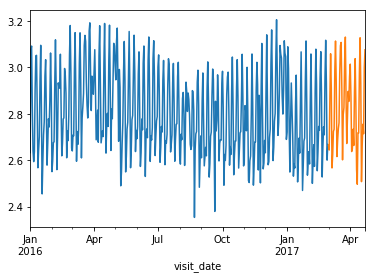

In [28]:
%matplotlib inline
df_train.groupby("visit_date")["visitors"].mean().plot()
df_test.groupby("visit_date")["visitors"].mean().plot()

In [29]:
print(
len(data["tra_as_hol"]["air_area_name"].unique()),
len(data["tra_as_hol"]["longitude"].unique()),
len(data["tra_as_hol"]["latitude"].unique()),
)
print(
len(data["tra_as_hol"].groupby(['latitude', 'longitude']).size()),
len(data["tra_as_hol"].groupby(["air_area_name",'latitude', 'longitude']).size())
)

103 108 108
108 108


For each store I use mean, min, max, std, area, genre, day and holiday as predictors

In [30]:
df_train

,air_store_id,visit_date,visitors,mean,min,max,std,time_numeric,month_1,month_2,...,air_area_name_Ōsaka-fu Sakai-shi Minamikawaramachi,air_area_name_Ōsaka-fu Suita-shi Izumichō,air_area_name_Ōsaka-fu Ōsaka-shi Fuminosato,air_area_name_Ōsaka-fu Ōsaka-shi Kyōmachibori,air_area_name_Ōsaka-fu Ōsaka-shi Kyūtarōmachi,air_area_name_Ōsaka-fu Ōsaka-shi Nakanochō,air_area_name_Ōsaka-fu Ōsaka-shi Nanbasennichimae,air_area_name_Ōsaka-fu Ōsaka-shi Shinmachi,air_area_name_Ōsaka-fu Ōsaka-shi Ōgimachi,air_area_name_Ōsaka-fu Ōsaka-shi Ōhiraki
0,air_ba937bf13d40fb24,2016-01-13,3.258096,22.782608,1.0,61.0,11.810526,1.036800e+10,1,0,...,0,0,0,0,0,0,0,0,0,0
1,air_ba937bf13d40fb24,2016-01-14,3.496508,22.782608,1.0,61.0,11.810526,1.123200e+10,1,0,...,0,0,0,0,0,0,0,0,0,0
2,air_ba937bf13d40fb24,2016-01-15,3.401197,22.782608,1.0,61.0,11.810526,1.209600e+10,1,0,...,0,0,0,0,0,0,0,0,0,0
3,air_ba937bf13d40fb24,2016-01-16,3.135494,22.782608,1.0,61.0,11.810526,1.296000e+10,1,0,...,0,0,0,0,0,0,0,0,0,0
4,air_ba937bf13d40fb24,2016-01-18,1.945910,22.782608,1.0,61.0,11.810526,1.468800e+10,1,0,...,0,0,0,0,0,0,0,0,0,0
5,air_ba937bf13d40fb24,2016-01-19,2.302585,22.782608,1.0,61.0,11.810526,1.555200e+10,1,0,...,0,0,0,0,0,0,0,0,0,0
6,air_ba937bf13d40fb24,2016-01-20,3.465736,22.782608,1.0,61.0,11.810526,1.641600e+10,1,0,...,0,0,0,0,0,0,0,0,0,0
7,air_ba937bf13d40fb24,2016-01-21,3.091043,22.782608,1.0,61.0,11.810526,1.728000e+10,1,0,...,0,0,0,0,0,0,0,0,0,0
8,air_ba937bf13d40fb24,2016-01-22,2.944439,22.782608,1.0,61.0,11.810526,1.814400e+10,1,0,...,0,0,0,0,0,0,0,0,0,0
9,air_ba937bf13d40fb24,2016-01-23,3.295837,22.782608,1.0,61.0,11.810526,1.900800e+10,1,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
def test(df_train,df_test,regr):
    #print(df_train.columns)
    try:
        X_train = df_train.drop(["visitors","visit_date","air_store_id","latitude","longitude"],axis=1).as_matrix()
        X_test =  df_test.drop(["visitors","visit_date","air_store_id","latitude","longitude"],axis=1).as_matrix()
    except:
        try:
            X_train = df_train.drop(["visitors","visit_date","air_store_id"],axis=1).as_matrix()
            X_test =  df_test.drop(["visitors","visit_date","air_store_id"],axis=1).as_matrix()
        except:
                    try:
                        X_train = df_train.drop(["col_visitors","col_visit_date","col_air_store_id","col_latitude","col_longitude"],axis=1).as_matrix()
                        X_test =  df_test.drop(["col_visitors","col_visit_date","col_air_store_id","col_latitude","col_longitude"],axis=1).as_matrix()
                    except:
                        X_train = df_train.drop(["col_visitors","col_visit_date","col_air_store_id"],axis=1).as_matrix()
                        X_test =  df_test.drop(["col_visitors","col_visit_date","col_air_store_id"],axis=1).as_matrix()
               
    # Split the targets into training/testing sets
    try:
        y_train = df_train["visitors"].values
        y_test =  df_test["visitors"].values
    except:
        y_train = df_train["col_visitors"].values
        y_test =  df_test["col_visitors"].values

    #print(X_train.shape,y_train.shape)
    #print(X_test.shape,y_test.shape)
    regr.fit(X_train, y_train)
    y_pred_train = regr.predict(X_train)
    y_pred = regr.predict(X_test)
    y_pred=np.maximum(0,y_pred)
    y_pred_train=np.maximum(0,y_pred_train)
    error=RMSE(y_test, y_pred)
    error_train=RMSE(y_train, y_pred_train)
    print(error,error_train)
    return error,error_train

In [41]:
df_train,df_test,df_eval=train_test_eval(enc,cut_date)
test(df_train,df_test, linear_model.LinearRegression())
df_train,df_test,df_eval=train_test_eval(enc2,cut_date)
test(df_train,df_test, linear_model.LinearRegression())

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


0.830475008524 0.803764798545
0.610495939967 0.596683098193


(0.61049593996712115, 0.59668309819291132)

In [42]:
#ensemble.RandomForestRegressor?

In [43]:
encoder = ce.BinaryEncoder(cols=cols_to_enc)
enc2=encoder.fit_transform(data["tra_as_hol"])

In [64]:
df_train,df_test,df_eval=train_test_eval(enc2,cut_date)
#df_train,df_test,df_eval=train_test_eval(enc,cut_date)

test(df_train,df_test, linear_model.LinearRegression())
test(df_train,df_test, linear_model.Ridge(alpha=0.001))
test(df_train,df_test, linear_model.Lasso(alpha=0.01))


#test(df_train,df_test, svm.SVR(C=0.01))
#test(df_train,df_test, svm.SVR(C=0.1))
#test(df_train,df_test, svm.SVR(C=1))
#test(df_train,df_test, svm.SVR(C=10))
#test(df_train,df_test, svm.SVR(C=100))

#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=100,max_features="sqrt",max_depth=20))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=5,max_features="sqrt",max_depth=20))
#test(df_train,df_test,ensemble.AdaBoostRegressor)
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=200,max_features="log2",max_depth=10))
test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=100,max_features="log2",max_depth=16))
test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=100,max_features="log2",max_depth=15))
test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=100,max_features="log2",max_depth=14))

#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=100,max_features="log2",max_depth=14))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=100,max_features="log2",max_depth=13))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=200,max_features="log2",max_depth=15))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=500,max_features="log2",max_depth=15))


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


0.610495792472 0.596683097947
0.610495973862 0.596683097938
0.614207413262 0.599476748557


KeyboardInterrupt: 

In [ ]:
test(df_train,df_test,ensemble.GradientBoostingRegressor(loss="ls", learning_rate=1, n_estimators=50,max_depth=5))
#test(df_train,df_test,ensemble.AdaBoostRegressor(n_estimators=100, learning_rate=0.5, loss="square"))

In [ ]:
#from xgboost import XGBClassifier

In [ ]:
"""
for fct in (ce.BinaryEncoder,ce.HashingEncoder,\
                ce.OneHotEncoder,ce.OrdinalEncoder,ce.PolynomialEncoder,\
                ce.BaseNEncoder,ce.LeaveOneOutEncoder):
    print(fct)
    encoder=fct(cols=cols_to_enc)
    enc=encoder.fit_transform(data["tra_as_hol"])
    df_train,df_test,df_eval=train_test_eval(enc,cut_date)
    test(df_train,df_test, linear_model.LinearRegression())

    
   
ce.BackwardDifferenceEncoder(cols=[...])
ce.BinaryEncoder(cols=[...])
ce.HashingEncoder(cols=[...])
ce.HelmertEncoder(cols=[...])
ce.OneHotEncoder(cols=[...])
ce.OrdinalEncoder(cols=[...])
ce.SumEncoder(cols=[...])
ce.PolynomialEncoder(cols=[...])
ce.BaseNEncoder(cols=[...])
ce.LeaveOneOutEncoder(cols=[...])
"""

## For submission

In [ ]:
df_eval

In [50]:
def make_csv(df_train,df_test,df_eval,regr,file):
    df_train_tot=df_train.append(df_test)
    print(df_train_tot.columns)
    print(df_eval.columns)
    X_train = df_train_tot.drop(["visitors","visit_date","air_store_id","latitude","longitude"],axis=1).as_matrix()
    X_test =  df_eval.drop(["visitors","visit_date","air_store_id","latitude","longitude"],axis=1).as_matrix()
    # Split the targets into training/testing sets
    y_train = df_train_tot["visitors"].values
    print(X_train.shape,y_train.shape)
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)
    y_pred=np.maximum(0,y_pred)
    y_pred=np.expm1(y_pred)
    df_eval["visitors"]=y_pred
    df_eval["id"]=df_eval["air_store_id"].map(str)+"_"+df_eval["visit_date"].dt.strftime('%Y-%m-%d')
    df_sub=df_eval[["id","visitors"]]
    df_sub.to_csv(file,index=False)

In [ ]:
df_eval=enc[enc.visitors.isna()]  
make_csv(df_train,df_test,df_eval,linear_model.LinearRegression(),"linear_binary.csv")

In [69]:
df_train,df_test,df_eval=train_test_eval(enc2,cut_date)
make_csv(df_train,df_test,df_eval,ensemble.RandomForestRegressor(n_estimators=90,max_features="log2",max_depth=18),
         "random_f_binary_log.csv")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


Index(['month_0', 'month_1', 'month_2', 'month_3', 'holiday_flg_0',
       'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'air_genre_name_0',
       'air_genre_name_1', 'air_genre_name_2', 'air_genre_name_3',
       'air_area_name_0', 'air_area_name_1', 'air_area_name_2',
       'air_area_name_3', 'air_area_name_4', 'air_area_name_5',
       'air_area_name_6', 'air_store_id', 'visit_date', 'visitors', 'latitude',
       'longitude', 'mean', 'min', 'max', 'std', 'time_numeric'],
      dtype='object')
Index(['month_0', 'month_1', 'month_2', 'month_3', 'holiday_flg_0',
       'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'air_genre_name_0',
       'air_genre_name_1', 'air_genre_name_2', 'air_genre_name_3',
       'air_area_name_0', 'air_area_name_1', 'air_area_name_2',
       'air_area_name_3', 'air_area_name_4', 'air_area_name_5',
       'air_area_name_6', 'air_store_id', 'visit_date', 'visitors', 'latitude',
       'longitude', 'mean', 'min', 'max', 'std', 'time_numeric'],
    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [ ]:
df_eval.columns

In [ ]:
df_test=data["tes"].merge(data["hol"],left_on="time",right_on="calendar_date").\
            drop("time",axis=1).\
            merge(data["as"],right_on="air_store_id",left_on="store_id").\
            drop(["store_id"],axis=1)

In [ ]:
df_test

In [ ]:
df_test["month"]=df_test.calendar_date.map(lambda x: x.month)
df_test["month"]=df_test["month"].astype('category')

In [ ]:
#cols_to_enc=["holiday_flg","air_genre_name","air_area_name","day_of_week"]
cols_to_enc=["month","holiday_flg","day_of_week","air_genre_name", 'air_area_name']
dummies=pd.get_dummies(df_test[cols_to_enc])
#data["tra_as_hol"].join(dummies)
df_test=df_test.join(dummies)
#enc.describe()
df_test=df_test.drop(cols_to_enc,axis=1).drop(["air_store_id","latitude","longitude"],axis=1)
enc.head()
for c in df_test.columns: print(c)
print(len(df_test.columns))

In [ ]:
df_train

### reservations

In [ ]:
#total number of reservations per day, for a stores
data["ar"]["visit_date"]=data["ar"]["visit_datetime"].map(lambda x:x.date())
data["ar"]["visit_date"]=pd.to_datetime(data["ar"]["visit_date"])
#data["ar"].groupby("air_store_id","visit_date")["reserve_visitors"].sum()

#data["ar"]
data["ar_sum"]=data["ar"].groupby(["air_store_id","visit_date"]) ["reserve_visitors"].sum().reset_index()
data["ar_sum"].head()

In [ ]:
#this contains only days with reservations
data["tra_ar_sum"]=data["ar_sum"].merge(data["tra_as_hol"],on=["visit_date","air_store_id"])
data["tra_ar_sum"].head()
df_train

In [ ]:
#cols_to_enc=["holiday_flg","air_genre_name","air_area_name","day_of_week"]
cols_to_enc=["month","holiday_flg","day_of_week","air_genre_name", 'air_area_name']
dummies=pd.get_dummies(data["tra_as_hol"][cols_to_enc])
#data["tra_as_hol"].join(dummies)
enc=data["tra_as_hol"].join(dummies)
#enc.describe()
enc=enc.drop(cols_to_enc,axis=1).drop(["air_store_id","latitude","longitude"],axis=1)
enc.head()
for c in enc.columns: print(c)
print(len(enc.columns))
#print(enc.columns)
df_train=enc[enc["visit_date"]<cut_date]
df_test= enc[enc["visit_date"]>= cut_date]

In [ ]:
from sklearn import *
print(df_train.columns)
X_train = df_train.drop(["visitors","visit_date"],axis=1).as_matrix()
X_test =  df_test.drop(["visitors","visit_date"],axis=1).as_matrix()
    # Split the targets into training/testing sets
y_train = df_train["visitors"].values
y_test =  df_test["visitors"].values
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
y_pred=np.maximum(0,y_pred)
error=RMSLE(y_test, y_pred)
print(error)

In [ ]:
df_store_test[["visitors","visitors_predicted"]]
df_test[["visitors","visitors_predicted"]]

In [ ]:
df_train.columns

In [ ]:
X_train = df_train.drop(["visitors","visit_date"],axis=1).values
X_test =  df_test.drop(["visitors","visit_date"],axis=1).values
# Split the targets into training/testing sets
y_train = df_train["visitors"].values
y_test =  df_test["visitors"].values

In [ ]:
y_train

In [ ]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)

### unique stores

In [ ]:
data["hr"]

In [ ]:
stores_tra=set(data["tra"].air_store_id.unique())
stores_ar=set(data["ar"].air_store_id.unique())
stores_hr=set(data["hr"].hpg_store_id.unique())
stores_as=set(data["as"].air_store_id.unique())
stores_hs=set(data["hs"].hpg_store_id.unique())
stores_id_a=set(data["id"].air_store_id.unique())
stores_id_h=set(data["id"].hpg_store_id.unique())
stores_tes=set(data["tes"].store_id.unique())

In [ ]:
stores_tes-stores_tra

In [ ]:
print(
    len(stores_tra),len(stores_ar),len(stores_as),len(stores_id_a),"\n",
                    len(stores_hr),len(stores_hs),len(stores_id_h),"\n",
    len(stores_tes))

In [ ]:
X_train

In [ ]:
df_train.shape,df_test.shape

### Time series

In [ ]:
data["tra_as_hol"]

In [ ]:
stores_groups=data["tra_as_hol"].groupby("air_store_id")

In [ ]:
series_test=stores_groups.get_group("air_00a91d42b08b08d9")[["visit_date","visitors"]]
series_test=series_test.set_index(series_test.visit_date).drop("visit_date",axis=1).dropna()
series_test.plot()

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(series_test, order=(1,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
residuals.plot(kind='kde')
print(residuals.describe())

In [ ]:
model_fit.fittedvalues.plot()
series_test.plot()

### DOW HOL average

In [ ]:
df_train,df_test,df_eval=train_test_eval(data["tra_as_hol"],cut_date)

In [ ]:
mean_store_dow_hol_month=df_train.groupby(["air_store_id","day_of_week","holiday_flg","month"]).visitors.mean().reset_index()
mean_store_dow_hol=df_train.groupby(["air_store_id","day_of_week","holiday_flg"]).visitors.mean().reset_index()
mean_store_dow=df_train.groupby(["air_store_id","day_of_week"]).visitors.mean().reset_index()
mean_store_hol=df_train.groupby(["air_store_id","holiday_flg"]).visitors.mean().reset_index()
mean_store=df_train.groupby(["air_store_id"]).visitors.mean().reset_index()

In [ ]:
mean_store_dow_hol.head()

In [ ]:
df_test.head()

In [ ]:
len(df_2)

In [ ]:
df_0_t=df_train.merge(mean_store_dow_hol_month,on=["air_store_id","day_of_week","holiday_flg","month"],how="left")
df_1_t=df_train.merge(mean_store_dow_hol,on=["air_store_id","day_of_week","holiday_flg"],how="left")
df_2_t=df_train.merge(mean_store_hol,on=["air_store_id","holiday_flg"],how="left")
df_3_t=df_train.merge(mean_store_dow,on=["air_store_id","day_of_week"],how="left")
df_4_t=df_train.merge(mean_store,on=["air_store_id"],how="left")
df_0=df_test.merge(mean_store_dow_hol_month,on=["air_store_id","day_of_week","holiday_flg","month"],how="left")
df_1=df_test.merge(mean_store_dow_hol,on=["air_store_id","day_of_week","holiday_flg"],how="left")
df_2=df_test.merge(mean_store_hol,on=["air_store_id","holiday_flg"],how="left")
df_3=df_test.merge(mean_store_dow,on=["air_store_id","day_of_week"],how="left")
df_4=df_test.merge(mean_store,on=["air_store_id"],how="left")
y_pred_0=df_0.visitors_y.values
y_pred_1=df_1.visitors_y.values
y_pred_2=df_2.visitors_y.values
y_pred_3=df_3.visitors_y.values
y_pred_4=df_4.visitors_y.values
y_test=df_1.visitors_x.values
y_pred_0_t=df_0_t.visitors_y.values
y_pred_1_t=df_1_t.visitors_y.values
y_pred_2_t=df_2_t.visitors_y.values
y_pred_3_t=df_3_t.visitors_y.values
y_pred_4_t=df_4_t.visitors_y.values
y_train=df_1_t.visitors_x.values


In [ ]:
for i,y in enumerate(y_pred_1):
    if np.isnan(y): 
        if not np.isnan(y_pred_2[i]): y_pred_1[i]=y_pred_2[i]
        else:
            if not np.isnan(y_pred_3[i]): y_pred_1[i]=y_pred_3[i]
            else:
                if not np.isnan(y_pred_4[i]):y_pred_1[i]=y_pred_4[i]
                else:y_pred_1[i]=0
                #y_pred_1[i]=0
for i,y in enumerate(y_pred_1_t):
    if np.isnan(y): 
        if not np.isnan(y_pred_2_t[i]): y_pred_1_t[i]=y_pred_2_t[i]
        else:
            if not np.isnan(y_pred_3_t[i]): y_pred_1_t[i]=y_pred_3_t[i]
            else:
                if not np.isnan(y_pred_4_t[i]):y_pred_1_t[i]=y_pred_4_t[i]
                else:y_pred_1_t[i]=0
        

In [ ]:
RMSLE(y_test,y_pred_1)

In [ ]:
RMSLE(y_train,y_pred_1_t)